# Part 2 – Data Preprocessing, Advanced EDA and Model Comparison

In this part, we will preprocess the data (normalization, encoding, missing value imputation), explain each technique, and perform advanced exploratory data analysis (EDA) on both the training and test sets.

In [89]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


### EDA and Preprocessing
We will analyze missing values, descriptive statistics, distributions, outliers, correlations, and relationships with the target variable for both train and test sets.

In [90]:
# Load the dataset and show the first 5 rows before selecting columns
raw_df = pd.read_csv("dataset/Real_Estate_Sales_2001-2022_GL.csv", low_memory=False)
print("Raw Data Sample (first 5 rows):")
display(raw_df.head(5))

Raw Data Sample (first 5 rows):


,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.5354,Residential,Single Family,NaN,NaN,NaN,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.4606,Residential,Three Family,NaN,NaN,NaN,NaN
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.6291,Residential,Two Family,NaN,NaN,NaN,NaN
4,210288,2021,06/20/2022,Avon,12 BYRON DRIVE,179990.0,362500.0,0.4965,Residential,Condo,NaN,NaN,NaN,POINT (-72.879115982 41.773452988)


In [91]:
def missing_values_table(df):
    mis_val = raw_df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(raw_df)
    table = pd.DataFrame({'Missing Values': mis_val, 'Percent': mis_val_percent})
    return table[table['Missing Values'] > 0].sort_values('Percent', ascending=False)

print("Missing values in the raw dataset:")
display(missing_values_table(raw_df))

Missing values in the raw dataset:


,Missing Values,Percent
OPM remarks,1084598,98.812805
Assessor Remarks,926401,84.400194
Location,799518,72.840459
Non Use Code,784178,71.442901
Residential Type,398389,36.295415
Property Type,382446,34.842921
Address,51,0.004646
Date Recorded,2,0.000182


#### Looking at the missing values, we can clearly filter out the OPM remarks, Assessor Remarks, Location, and Non Use Code columns.
The residential type and property type missing in such a large quantity is concerning as it would be useful data for our model. We should look at these missing values.

In [92]:
# Select relevant columns
selected_columns = [
    "List Year",        # numeric (int)
    "Date Recorded",    # categoric (str)
    "Town",             # categoric (str)
    "Address",          # categoric (str)
    "Assessed Value",   # numeric (int)
    "Sale Amount",      # numeric (int) - target
    "Property Type",    # categoric (str)
    "Residential Type"  # categoric (str)
]

In [93]:
df = raw_df[selected_columns]
df = df.dropna(subset=["Sale Amount"])  # eliminate rows with NaN in 'Sale Amount'
print("Selected Columns Sample (first 5 rows):")
display(df.head(5))

# Print the first 5 rows where 'Property Type' is missing
missing_property_type = df[df['Property Type'].isnull()]
print("Rows with missing Property Type (first 5):")
display(missing_property_type.head(5))

Selected Columns Sample (first 5 rows):


,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Property Type,Residential Type
0,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,Residential,Single Family
1,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,Residential,Three Family
2,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,Commercial,NaN
3,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,Residential,Two Family
4,2021,06/20/2022,Avon,12 BYRON DRIVE,179990.0,362500.0,Residential,Condo


Rows with missing Property Type (first 5):


,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Property Type,Residential Type
326,2001,01/10/2002,Danbury,166 OLD BROOKFIELD RD,81100.0,180000.0,NaN,NaN
327,2001,08/16/2002,Guilford,6 LAUREL RDG,187530.0,386500.0,NaN,NaN
332,2001,02/27/2002,Bethel,211 LEXINGTON BLVD,47600.0,109900.0,NaN,NaN
335,2001,06/18/2002,Hampton,741 POMFRET RD,60260.0,145500.0,NaN,NaN
337,2001,01/02/2002,Branford,28 SUNDANCE,42210.0,65900.0,NaN,NaN


#### We should plot the number of missing fields with time as that might give us a hint as to why this is happening.

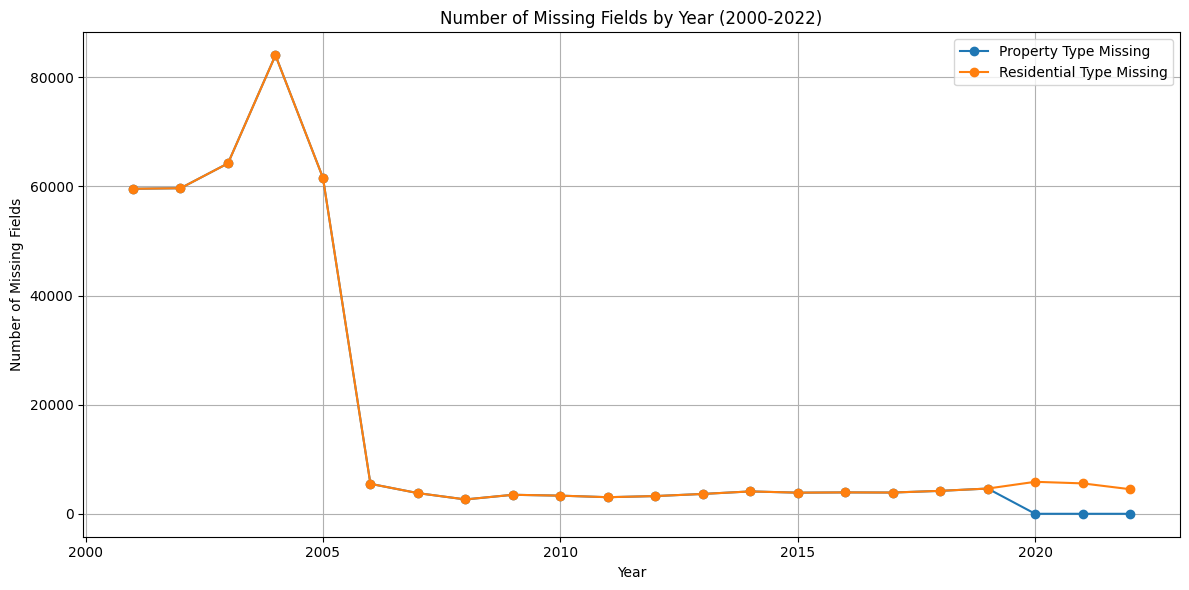

In [94]:
# Plot the number of missing 'Property Type' and 'Residential Type' fields by year (2000-2022)
missing_by_year = df.copy()
missing_by_year['Property Type Missing'] = missing_by_year['Property Type'].isnull()
missing_by_year['Residential Type Missing'] = missing_by_year['Residential Type'].isnull()

missing_counts = missing_by_year.groupby('List Year')[['Property Type Missing', 'Residential Type Missing']].sum()

plt.figure(figsize=(12, 6))
plt.plot(missing_counts.index, missing_counts['Property Type Missing'], label='Property Type Missing', marker='o')
plt.plot(missing_counts.index, missing_counts['Residential Type Missing'], label='Residential Type Missing', marker='o')
plt.title('Number of Missing Fields by Year (2000-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Missing Fields')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Missing fields are predominantly before 2006/2007 so we might get better results by removing all fields with a missing property type

In [100]:
# Remove all rows with a missing 'Property Type' and reset the index
print(f"Rows before removing missing 'Property Type': {len(df)}")
df = df[df['Property Type'].notnull()].copy()
df.reset_index(drop=True, inplace=True)
print(f"Rows after removing missing 'Property Type': {len(df)}")
# Show updated missing values table for the filtered DataFrame
def missing_values_table_local(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    table = pd.DataFrame({'Missing Values': mis_val, 'Percent': mis_val_percent})
    return table[table['Missing Values'] > 0].sort_values('Percent', ascending=False)
display(missing_values_table_local(df))

Rows before removing missing 'Property Type': 715183
Rows after removing missing 'Property Type': 715183


,Missing Values,Percent
Residential Type,15943,2.22922


#### We lost quite a bit of data, but our dataset should be cleaner. We cannot remove missing residential types as they are due to the commercial/vacant land property type. This won't be an issue as we will be one-hot encoding these columns. Next we should check out the statistics of our columns.

In [101]:
# Show descriptive statistics for the cleaned dataset
display(df.describe(include='all'))

,List Year,Town,Assessed Value,Sale Amount,Property Type,Residential Type,Log Assessed Value,Log Sale Amount
count,715183.000000,715183,7.151830e+05,7.151830e+05,715183,699240,715183.000000,715183.000000
unique,NaN,170,NaN,NaN,11,5,NaN,NaN
top,NaN,Bridgeport,NaN,NaN,Single Family,Single Family,NaN,NaN
freq,NaN,22221,NaN,NaN,401612,508044,NaN,NaN
mean,2014.855875,NaN,2.633376e+05,4.009725e+05,NaN,NaN,11.994965,12.403460
std,4.938425,NaN,1.368058e+06,6.055746e+06,NaN,NaN,1.075662,0.917037
min,2006.000000,NaN,0.000000e+00,0.000000e+00,NaN,NaN,0.000000,0.000000
25%,2011.000000,NaN,1.097600e+05,1.550000e+05,NaN,NaN,11.606061,11.951187
50%,2015.000000,NaN,1.597000e+05,2.450000e+05,NaN,NaN,11.981059,12.409018
75%,2019.000000,NaN,2.492700e+05,3.899000e+05,NaN,NaN,12.426296,12.873648


#### Both the address and date recorded are unhelpful to us so we will remove those columns.

In [97]:
selected_columns = [
    "List Year",        # numeric (int)
    "Town",             # categoric (str)
    "Assessed Value",   # numeric (int)
    "Sale Amount",      # numeric (int) - target
    "Property Type",    # categoric (str)
    "Residential Type"  # categoric (str)
]
df = df[selected_columns]
display(df.head(5))

,List Year,Town,Assessed Value,Sale Amount,Property Type,Residential Type
0,2020,Ansonia,133000.0,248400.0,Residential,Single Family
1,2020,Ansonia,110500.0,239900.0,Residential,Three Family
2,2020,Ansonia,150500.0,325000.0,Commercial,NaN
3,2020,Ansonia,127400.0,202500.0,Residential,Two Family
4,2021,Avon,179990.0,362500.0,Residential,Condo


#### We should plot our Assesed Value and Sale Amount to see how they vary with time

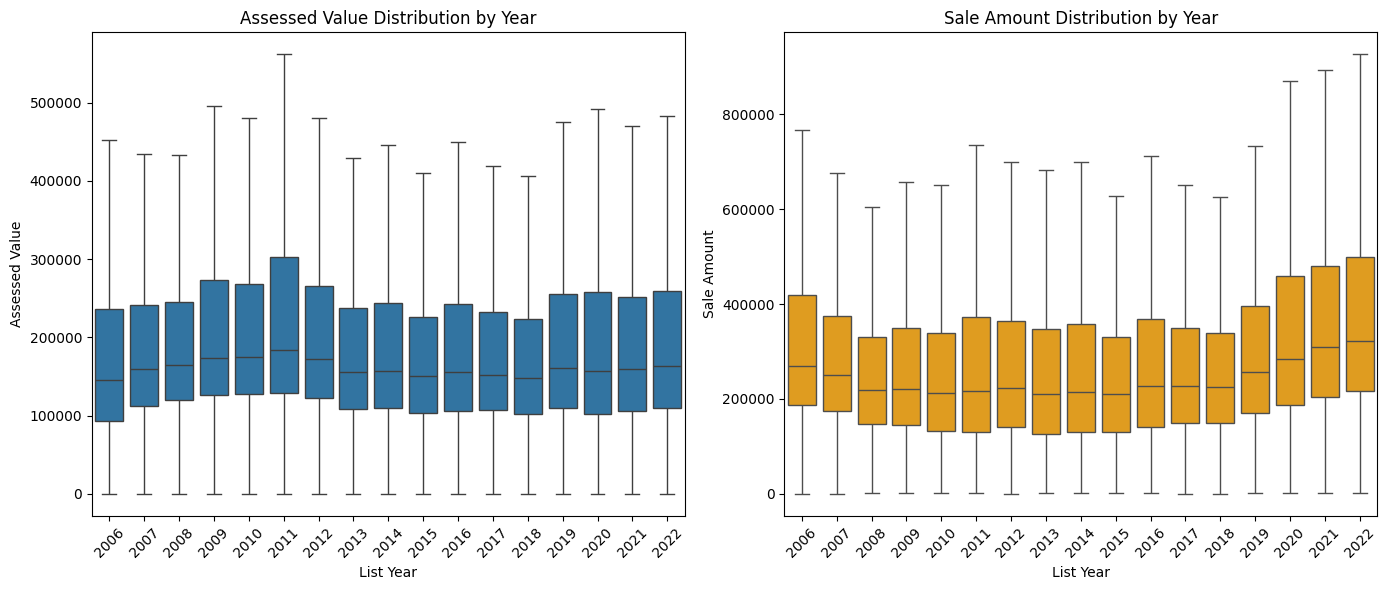

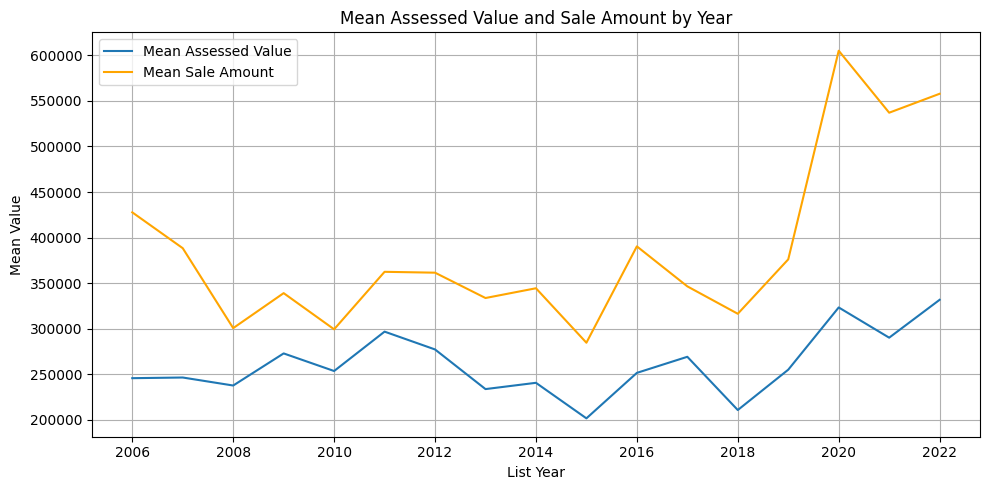

In [98]:
# Plot Assessed Value and Sale Amount by List Year as boxplots and lineplots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x="List Year", y="Assessed Value", data=df, showfliers=False)
plt.title("Assessed Value Distribution by Year")
plt.xlabel("List Year")
plt.ylabel("Assessed Value")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x="List Year", y="Sale Amount", data=df, showfliers=False, color="orange")
plt.title("Sale Amount Distribution by Year")
plt.xlabel("List Year")
plt.ylabel("Sale Amount")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Also show mean values as lineplots for additional insight
plt.figure(figsize=(10, 5))
df_grouped = df.groupby("List Year").agg({"Assessed Value": "mean", "Sale Amount": "mean"})
plt.plot(df_grouped.index, df_grouped["Assessed Value"], label="Mean Assessed Value")
plt.plot(df_grouped.index, df_grouped["Sale Amount"], label="Mean Sale Amount", color="orange")
plt.title("Mean Assessed Value and Sale Amount by Year")
plt.xlabel("List Year")
plt.ylabel("Mean Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### We have extreme variance and a lot of outliers.
We will try log transforming both of these columns to see if that helps.

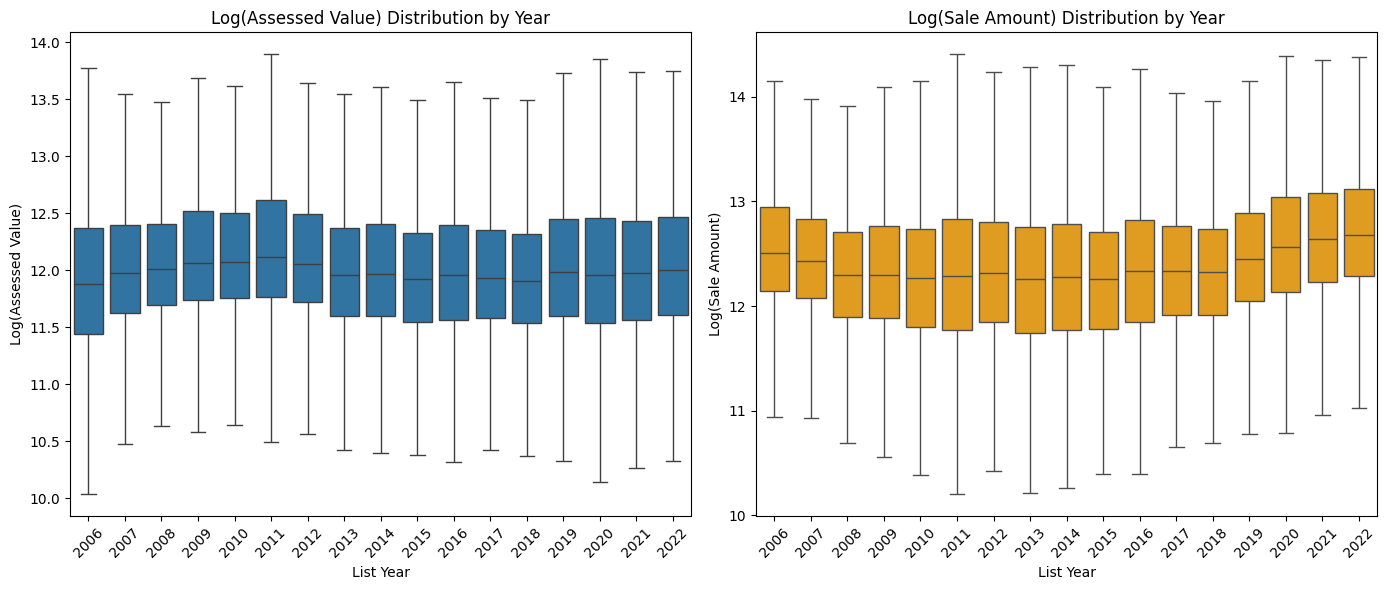

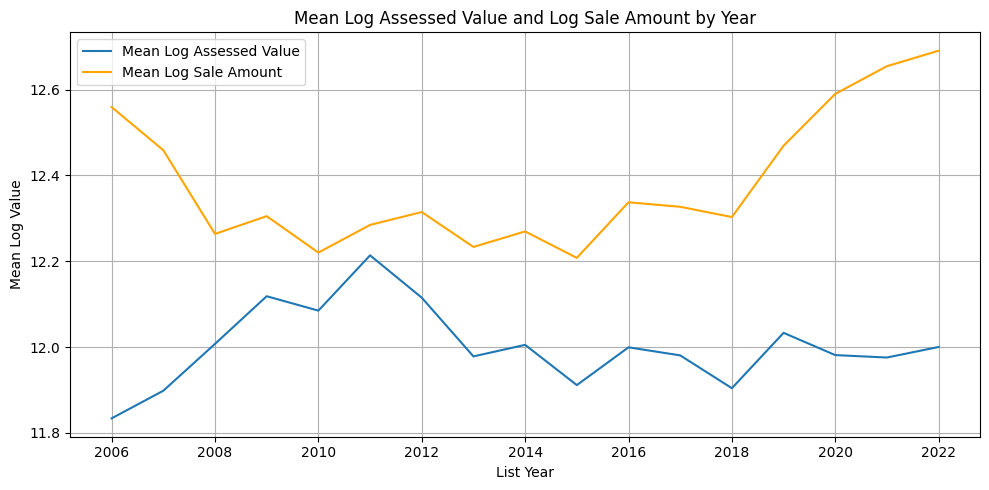

In [99]:
# Log-transform Assessed Value and Sale Amount
import numpy as np
df['Log Assessed Value'] = np.log1p(df['Assessed Value'])
df['Log Sale Amount'] = np.log1p(df['Sale Amount'])

# Plot boxplots of log-transformed values by year
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x="List Year", y="Log Assessed Value", data=df, showfliers=False)
plt.title("Log(Assessed Value) Distribution by Year")
plt.xlabel("List Year")
plt.ylabel("Log(Assessed Value)")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x="List Year", y="Log Sale Amount", data=df, showfliers=False, color="orange")
plt.title("Log(Sale Amount) Distribution by Year")
plt.xlabel("List Year")
plt.ylabel("Log(Sale Amount)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Plot mean log values as lineplots
plt.figure(figsize=(10, 5))
df_grouped_log = df.groupby("List Year").agg({"Log Assessed Value": "mean", "Log Sale Amount": "mean"})
plt.plot(df_grouped_log.index, df_grouped_log["Log Assessed Value"], label="Mean Log Assessed Value")
plt.plot(df_grouped_log.index, df_grouped_log["Log Sale Amount"], label="Mean Log Sale Amount", color="orange")
plt.title("Mean Log Assessed Value and Log Sale Amount by Year")
plt.xlabel("List Year")
plt.ylabel("Mean Log Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Log Transformation Effects
Applying the natural logarithm to Assessed Value and Sale Amount reduces the impact of extreme outliers and compresses the range of values. This makes the distributions more symmetric and closer to normal. The boxplots above show that the spread of values is reduced and the presence of extreme values is less pronounced. The line plots of mean log values by year reveal smoother trends, making it easier to compare changes over time.